#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

#### This notebook does not include the raw data files. In order to run the notebook, you need to download them from https://fastmri.med.nyu.edu/

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import os

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
path = '/home/yusuf/Desktop/projects/data/fastmri/multicoil_train'
data = os.listdir(path)
file_name = f'{path}/{data[0]}'
hf = h5py.File(file_name)

In [3]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT1PRE', 'max': 0.0006719433863854638, 'norm': 0.13677620325977113, 'patient_id': '74f03e747d64eb7de9b7f7ec849ef67b612768872224770a4b969f69e1244de1'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [14]:
volume_kspace = hf['reconstruction_rss'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

float32
(16, 320, 320)


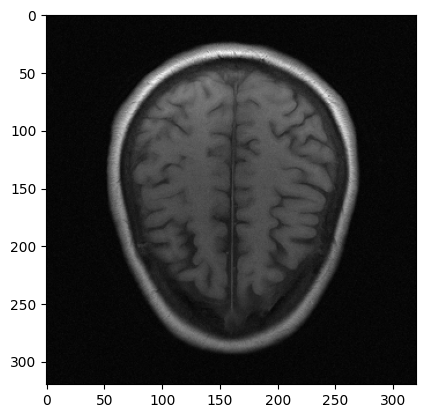

In [17]:
plt.imshow(volume_kspace[6],cmap="gray")

In [19]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 14, 640, 320)


In [20]:
slice_kspace = volume_kspace[6] # Choosing the *16-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [21]:
def show_coils(data, slice_nums, cmap="gray"):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.axis('off')
        plt.imshow(data[num], cmap=cmap)

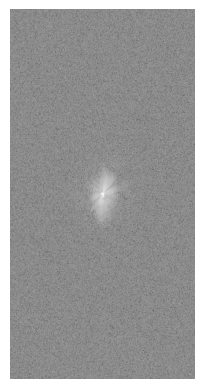

In [22]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0])  # This shows coils 0, *1 and *2

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [18]:
import fastmri
from fastmri.data import transforms as T

In [23]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

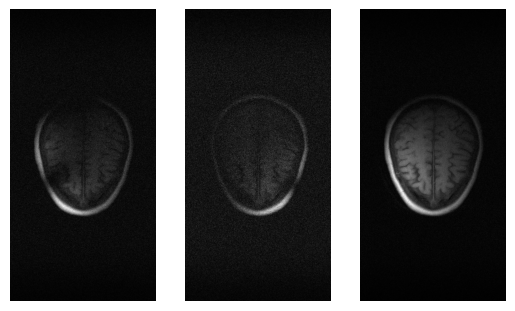

In [24]:
show_coils(slice_image_abs, [0, 1, 2], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [25]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

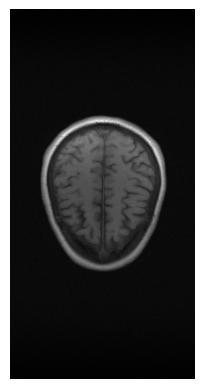

In [29]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')
plt.axis('off')
plt.show()

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [59]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])  # Create the mask function object

In [60]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [61]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

In [62]:
masked_kspace.shape, mask.shape

(torch.Size([14, 640, 320, 2]), torch.Size([1, 1, 320, 1]))

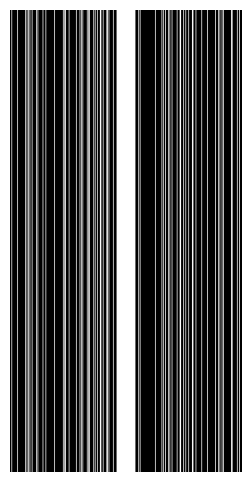

In [63]:
mask_1d = mask.squeeze()

# Repeat the mask along the vertical axis to get the desired shape (640, 320)
mask_2d_expanded = np.tile(mask_1d, (640, 1))

# Plot the expanded mask
plt.figure(figsize=(6, 6))
plt.imshow(mask_2d_expanded, cmap='gray')
plt.axis("off")
plt.show()

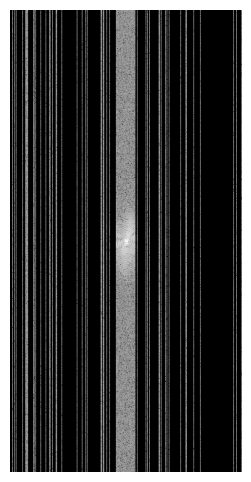

In [46]:
plt.figure(figsize=(6, 6))
plt.imshow(np.log(np.abs(masked_kspace[0,:,:,0].numpy()) + 1e-9), cmap='gray')
plt.axis('off')
plt.show()

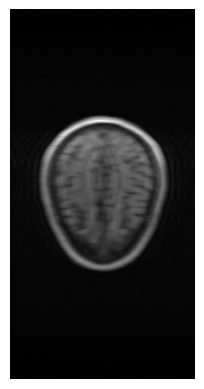

In [48]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')
plt.axis('off')
plt.show()